In [ ]:
'''
Buidling FPGA_Reshaper class from fpga_support.py file step by step
'''

__author__ = "Abarajithan G"
__copyright__ = "Copyright 2019, Final Year Project"
__credits__ = ["Abarajithan G"]
__version__ = "1.0.0"
__maintainer__ = "Abarajthan G"
__email__ = "abarajithan07@gmail.com"
__status__ = "Research"

In [202]:
import numpy as np
import pickle
from yolov2_numpy import *
from conv import *

In [203]:
yolo = pickle.load(open('yolo_16_layers.pickle','rb'))

In [206]:
# 3x3 Kernel reshaping for multiple cores (case 1)
i = 1
n = 2
m = 1

if m:
    p = n//2
else:
    p = n

kernel_orig = yolo[f'conv2d_{i}'].weights
kernel = yolo[f'conv2d_{i}'].weights         # (3, 3, cin, cout)      : (3, 3, 64, 128) - Layer 3
k,_,cin,cout = kernel.shape

if m and cin % 2:
    cin += 1
    dummy_cin = np.zeros((k,k,1,cout),np.float16)
    kernel = np.concatenate([kernel, dummy_cin],axis=2)

# itr = cout//p
itr = cout//p + (cout % p != 0)                                                 # itr               = 64 % 6 + 1  = 10 + 1 = 11
cout_fpga = itr*p                                                               # cout_fpga         = 11 * 6      = 66
if cout % p:
    cout_first_valid = cout % p                                                 # cout_first_valid  = 64 % 6      = 4
else:
    cout_first_valid = p
cout_first_invalid = p - cout_first_valid                                       # cout_first_invalid=  6 - 4      = 2

kernel_invalid = np.zeros((k,k,cin,cout_first_invalid),dtype=np.float16)            # (cin, cout_first_invalid): (128,  2)
kernel_valid = kernel[:,:,:, 0:cout_first_valid]                                    # (cin, cout_first_valid)  : (128,  4)
kernel_rest  = kernel[:,:,:, cout_first_valid:]                                     # (cin, cout-cout_f_valid) : (128, 60)

kernel = np.concatenate([kernel_valid, kernel_invalid, kernel_rest], axis=3)    # (cin, [v, inv, rest])    : (128, [4+2+60])
assert kernel.shape == (k,k,cin,cout_fpga)                                          # (cin, cout_fpga)         : (128, 66)
#######

kernel = kernel.reshape((k**2, cin, cout_fpga))   # (9, cin, cout)         : (9, 64, 128)
kernel = kernel.reshape((k**2, cin, itr, p))      # (9, cin, cout/p, p)    : (9, 64, 64, 2)
kernel = kernel.transpose((2,1,3,0))         # (cout/p, cin, p, 9)    : (64, 64, 2, 9)
kernel = kernel.reshape((itr, cin, 9*p))     # (cout/p, cin, 9p)      : (64, 64, 18)
kernel = kernel.reshape((itr, cin, 3, 3*p))  # (cout/p, cin, 3, 3p)   : (64, 64, 3, 6)
kernel = kernel.reshape((itr, cin*3, 3*p))   # (cout/p, 3*cin, 3p)    : (64, 192, 6)

bias = yolo[f'conv2d_{i}'].biases            # (cout,)         : (128,) - Layer 3

bias_invalid = np.zeros(cout_first_invalid,dtype=np.float16)                  # (cout_first_invalid,)    : (2)
bias_valid = bias[0:cout_first_valid]                                       # (cout_first_valid,)      : (4)
bias_rest  = bias[cout_first_valid:]                                        # (cout-cout_f_valid)      : (60)

bias = np.concatenate([bias_valid, bias_invalid ,bias_rest])            # ([invalid,valid, rest])  : ([2+4+64])
assert bias.shape[0] == cout_fpga                                             # (cout_fpga)              : (66,)

bias = bias.reshape(itr,p)                   # (cout/p, p)     : (64, 2)
bias = bias.repeat(3, axis=1)                # (cout/p,3p)     : (64, 6)
bias = bias.reshape(itr, 1, 3*p)              # (cout/p, 1, 3p): (64, 1, 6)

if m:
    kernel = kernel.reshape((itr, cin*3//2, 3*n))
    bias = bias.repeat(2, axis=2)

'''Bias comes last'''
weights = np.concatenate([kernel,bias], axis = 1) # (cout/p, 3*cin/max_factor + 1, 3*p*max_factor)   : (6, 193, 64)
print(weights.shape)
weights = weights.flatten()                       # (3*cout*(3*cin+1))       : (74112)

kernel.shape, bias.shape, weights.shape

(32, 7, 6)


((32, 6, 6), (32, 1, 6), (1344,))

In [193]:
weights_bytes = weights.flatten().tobytes()

with open(f'cores/6/txt/{i}_wb.txt', 'w') as f:
    weights_int16 = np.frombuffer(weights_bytes, dtype=np.uint16)
    for k in weights_int16:
        f.write(str(k)+'\n')

with open(f'cores/6/mem_bin/{i}_wb.bin', 'wb') as f:
    f.write(weights_bytes)

In [61]:
'''
Single iteration for testing
'''

len_one = len(weights)//kernel.shape[0]
weights_itr_1 = weights[0:len_one]

with open(f'cores/wb_{i}_itr_1.txt', 'w') as f:
    weights_int16 = np.frombuffer(weights_itr_1.tobytes(), dtype=np.uint16)
    for k in weights_int16:
        f.write(str(k)+'\n')

In [339]:
len_one = len(weights)//kernel.shape[0]
kernel.shape

(32, 6, 6)

In [178]:
# 1x1 Kernel reshaping for multiple cores (case 6)

i = 4
n = 6

# Example: Layer i=4, cores n=8 cores
p = 3*n                                                                         # p = 6
kernel = yolo[f'conv2d_{i}'].weights                                            # (1,1,cin,cout) : (1,1,128,64)
k,_,cin,cout = kernel.shape
kernel = kernel.squeeze()                                                       # (cin,cout)     : (128,64)

itr = cout//p + (cout % p != 0)                                                 # itr               = 64 % 6 + 1  = 10 + 1 = 11
cout_fpga = itr*p                                                               # cout_fpga         = 11 * 6      = 66
cout_first_valid = cout % p                                                     # cout_first_valid  = 64 % 6      = 4
cout_first_invalid = p - cout_first_valid                                       # cout_first_invalid=  6 - 4      = 2

kernel_invalid = np.zeros((cin,cout_first_invalid),dtype=np.float16)            # (cin, cout_first_invalid): (128,  2)
kernel_valid = kernel[:, 0:cout_first_valid]                                    # (cin, cout_first_valid)  : (128,  4)
kernel_rest  = kernel[:, cout_first_valid:]                                     # (cin, cout-cout_f_valid) : (128, 60)

kernel = np.concatenate([kernel_valid, kernel_invalid, kernel_rest], axis=1)    # (cin, [v, inv, rest])    : (128, [4+2+60])
assert kernel.shape == (cin,cout_fpga)                                          # (cin, cout_fpga)         : (128, 66)

kernel = kernel.reshape((cin, itr, 3, n))                                       # (cin, itr,  3, n)        : (128, 11,  3, 2)
kernel = np.flip(kernel, axis=2)                                                # (cin, itr, -3, n)        : (128, 11, -3, 2)
kernel = np.einsum('ijkl->jilk',kernel)                                         # (itr, cin,  n, 3)        : (11, 128,  2, 3)
kernel = kernel.reshape((itr, cin, 3*n))                                        # (itr, cin,  3*n )        : (11, 128,  6)

biases = yolo[f'conv2d_{i}'].biases                                             # (cout,)                  : (64,)
assert cout == biases.size

biases_invalid = np.zeros(cout_first_invalid,dtype=np.float16)                  # (cout_first_invalid,)    : (2)
biases_valid = biases[0:cout_first_valid]                                       # (cout_first_valid,)      : (4)
biases_rest  = biases[cout_first_valid:]                                        # (cout-cout_f_valid)      : (60)

biases = np.concatenate([biases_valid, biases_invalid ,biases_rest])            # ([invalid,valid, rest])  : ([2+4+64])
assert biases.shape[0] == cout_fpga                                             # (cout_fpga)              : (66,)

biases = biases.reshape((itr,3,n))                                              # (itr,  3,  n)            : (11, 3, 2)
biases = np.flip (biases, axis = 1)                                             # (itr, -3,  n)            : (11,-3, 2)
biases = np.einsum('jkl->jlk',biases)                                           # (itr,  n,  3)            : (11, 2, 3)
biases = biases.reshape((itr,1,3*n))                                            # (itr, 1, 3*n)            : (11, 1, 6)

'''Biases at the end'''
weights = np.concatenate([kernel, biases], axis=1)                              # (itr, cin+1, 3*n)        : (11, 129, 6)

kernel.shape, biases.shape, weights.shape

((4, 128, 18), (4, 1, 18), (4, 129, 18))

In [147]:
weights[4,90,:]

array([-0.1887,  0.2457, -0.501 , -0.1315, -0.1091,  0.1781],
      dtype=float16)

In [164]:
# a = np.frombuffer(weights.flatten().tobytes(),np.uint16)
# b = weights.flatten()
# for i in range(len(b)):
#     print(a[i],b[i])

In [51]:
def make_weights(i, yolo, num_cores=2, to_txt=False, to_bin=False, path='cores/'):
    ''' Check Maxpool '''
    try:
        a = yolo[f'maxpool_{i}']
        m = 1
    except:
        m = 0
        
    n = num_cores
        
    kernel = yolo[f'conv2d_{i}'].weights                    # (3, 3, cin, cout)        : (3, 3, 64, 128) - Layer 3
    biases = yolo[f'conv2d_{i}'].biases                     # (cout,)                  : (128,)          - Layer 3
    
    k,_,cin,cout = kernel.shape
    kernel_shape_orig = kernel.shape
    biases_shape_orig = biases.shape
    
    ''' Check 3x3 or 1x1 '''
    if k == 3:
        
        if m:
            p = n//2
        else:
            p = n

        kernel_orig = yolo[f'conv2d_{i}'].weights
        kernel = yolo[f'conv2d_{i}'].weights         # (3, 3, cin, cout)      : (3, 3, 64, 128) - Layer 3
        k,_,cin,cout = kernel.shape

        if m and cin % 2:
            cin += 1
            dummy_cin = np.zeros((k,k,1,cout),np.float16)
            kernel = np.concatenate([kernel, dummy_cin],axis=2)

        itr = cout//p + (cout % p != 0)
        kernel = kernel.reshape((k**2, cin, cout))   # (9, cin, cout)         : (9, 64, 128)
        kernel = kernel.reshape((k**2, cin, itr, p)) # (9, cin, cout/p, p)    : (9, 64, 64, 2)
        kernel = kernel.transpose((2,1,3,0))         # (cout/p, cin, p, 9)    : (64, 64, 2, 9)
        kernel = kernel.reshape((itr, cin, 9*p))     # (cout/p, cin, 9p)      : (64, 64, 18)
        kernel = kernel.reshape((itr, cin, 3, 3*p))  # (cout/p, cin, 3, 3p)   : (64, 64, 3, 6)
        kernel = kernel.reshape((itr, cin*3, 3*p))   # (cout/p, 3*cin, 3p)    : (64, 192, 6)

        bias = yolo[f'conv2d_{i}'].biases            # (cout,)         : (128,) - Layer 3
        bias = bias.reshape(itr,p)                   # (cout/p, p)     : (64, 2)
        bias = bias.repeat(3, axis=1)                # (cout/p,3p)     : (64, 6)
        bias = bias.reshape(itr, 1, 3*p)             # (cout/p, 1, 3p): (64, 1, 6)

        if m:
            kernel = kernel.reshape((itr, cin*3//2, 3*n))
            bias = bias.repeat(2, axis=2)

        '''Bias comes last'''
        weights = np.concatenate([kernel,bias], axis = 1) # (cout/p, 3*cin+1, 3*p)   : (6, 193, 64)
        weights = weights.flatten()                       # (3*cout*(3*cin+1))       : (74112)
        
    else:
        p = 3*n                                                                         # p = 6
        kernel = kernel.squeeze()                                                       # (cin,cout)     : (128,64)

        itr = cout//p + (cout % p != 0)                                                 # itr               = 64 % 6 + 1  = 10 + 1 = 11
        cout_fpga = itr*p                                                               # cout_fpga         = 11 * 6      = 66
        cout_first_valid = cout % p                                                     # cout_first_valid  = 64 % 6      = 4
        cout_first_invalid = p - cout_first_valid                                       # cout_first_invalid=  6 - 4      = 2

        kernel_invalid = np.zeros((cin,cout_first_invalid),dtype=np.float16)            # (cin, cout_first_invalid): (128,  2)
        kernel_valid = kernel[:, 0:cout_first_valid]                                    # (cin, cout_first_valid)  : (128,  4)
        kernel_rest  = kernel[:, cout_first_valid:]                                     # (cin, cout-cout_f_valid) : (128, 60)

        kernel = np.concatenate([kernel_valid, kernel_invalid, kernel_rest], axis=1)    # (cin, [v, inv, rest])    : (128, [4+2+60])
        assert kernel.shape == (cin,cout_fpga)                                          # (cin, cout_fpga)         : (128, 66)

        kernel = kernel.reshape((cin, itr, 3, n))                                       # (cin, itr,  3, n)        : (128, 11,  3, 2)
        kernel = np.flip(kernel, axis=2)                                                # (cin, itr, -3, n)        : (128, 11, -3, 2)
        kernel = np.einsum('ijkl->jilk',kernel)                                         # (itr, cin,  n, 3)        : (11, 128,  2, 3)
        kernel = kernel.reshape((itr, cin, 3*n))                                        # (itr, cin,  3*n )        : (11, 128,  6)

        biases = yolo[f'conv2d_{i}'].biases                                             # (cout,)                  : (64,)
        assert cout == biases.size

        biases_invalid = np.zeros(cout_first_invalid,dtype=np.float16)                  # (cout_first_invalid,)    : (2)
        biases_valid = biases[0:cout_first_valid]                                       # (cout_first_valid,)      : (4)
        biases_rest  = biases[cout_first_valid:]                                        # (cout-cout_f_valid)      : (60)

        biases = np.concatenate([biases_valid, biases_invalid ,biases_rest])            # ([invalid,valid, rest])  : ([2+4+64])
        assert biases.shape[0] == cout_fpga                                             # (cout_fpga)              : (66,)

        biases = biases.reshape((itr,3,n))                                              # (itr,  3,  n)            : (11, 3, 2)
        biases = np.flip (biases, axis = 1)                                                     # (itr, -3,  n)            : (11,-3, 2)
        biases = np.einsum('jkl->jlk',biases)                                           # (itr,  n,  3)            : (11, 2, 3)
        biases = biases.reshape((itr,1,3*n))                                            # (itr, 1, 3*n)            : (11, 1, 6)

        '''Biases at the end'''
        weights = np.concatenate([kernel, biases], axis=1)                              # (itr, cin+1, 3*n)        : (11, 129, 6)
        weights = weights.flatten()                                                     # (3*n*itr*(cin+1))

    weights_bytes = weights.tobytes()
    print(f'{i}\t{k}\t{m}\t{str(kernel_shape_orig):<20s} {str(biases_shape_orig):<10s} {str(kernel.shape):<18s} {biases.shape} \t{str(weights.shape):<15s}\t{len(weights_bytes)}')
    
    '''
    Cross Check SOC's formula
    '''
#     assert weights.size == 3 * (n * itr) * (k * cin/max_factor + 1)  # Compare with C code's calculation not correct for 1x1
    
    if to_txt:
        with open(path + f'txt/{i}_wb.txt', 'w') as f:
            weights_int16 = np.frombuffer(weights_bytes, dtype=np.uint16)
            for k in weights_int16:
                f.write(str(k)+'\n')
    if to_bin:
        with open(path + f'mem_bin/{i}_wb.bin', 'wb') as f:
            f.write(weights_bytes)
        

def make_weights_all(yolo, num_cores=2,to_txt=False,to_bin=False, path='cores/'):
    print(f'i\tk\tm\t{"ker_orig":<20s} {"b_orig":<10s} {"ker_out":<18s} b_out \tweights_out \tweights_bytes')
    for i in range(1,24):
        make_weights(i, yolo=yolo, num_cores=num_cores, to_txt=to_txt, to_bin=to_bin, path=path)

In [54]:
make_weights_all(yolo, num_cores=8, to_txt=True,to_bin=True, path='cores/8/')

i	k	m	ker_orig             b_orig     ker_out            b_out 	weights_out 	weights_bytes
1	3	1	(3, 3, 3, 32)        (32,)      (8, 6, 24)         (32,) 	(1344,)        	2688
2	3	1	(3, 3, 32, 64)       (64,)      (16, 48, 24)       (64,) 	(18816,)       	37632
3	3	0	(3, 3, 64, 128)      (128,)     (16, 192, 24)      (128,) 	(74112,)       	148224
4	1	0	(1, 1, 128, 64)      (64,)      (3, 128, 24)       (3, 1, 24) 	(9288,)        	18576
5	3	1	(3, 3, 64, 128)      (128,)     (32, 96, 24)       (128,) 	(74496,)       	148992
6	3	0	(3, 3, 128, 256)     (256,)     (32, 384, 24)      (256,) 	(295680,)      	591360
7	1	0	(1, 1, 256, 128)     (128,)     (6, 256, 24)       (6, 1, 24) 	(37008,)       	74016
8	3	1	(3, 3, 128, 256)     (256,)     (64, 192, 24)      (256,) 	(296448,)      	592896
9	3	0	(3, 3, 256, 512)     (512,)     (64, 768, 24)      (512,) 	(1181184,)     	2362368
10	1	0	(1, 1, 512, 256)     (256,)     (11, 512, 24)      (11, 1, 24) 	(135432,)      	270864
11	3	0	(3, 3, 256, 51

In [55]:
def make_image(i, yolo=yolo, conv_units=8, to_txt=False, to_bin=False, path='cores/'):
    try:
        a = yolo[f'maxpool_{i}']
        m = True
        max_factor = 2
    except:
        m = False
        max_factor = 1

    image = yolo[f'conv2d_{i}'].in_data[0]
    assert len(image.shape) == 3
    h,w,c  = image.shape
    blocks = h//conv_units
    image  = np.pad(image,((1,1),(0,0),(0,0)),mode = 'constant')
    
    image  = image.astype(np.float16)
    
    if m:
        if c%2:
            c = c+1 
            h1,w1,_ = image.shape
            zeros = np.zeros((h1,w1,1), dtype=np.float16)
            image = np.concatenate([image,zeros], axis=2)
            
        im_arrays = [np.empty((0),dtype = np.float16), np.empty((0),dtype = np.float16)]
        for k in range(blocks):
            temp = image[k*conv_units:(k+1)*conv_units+2,:,:]
            temp = np.transpose(temp,[1,2,0]).flatten()
            im_arrays[k % 2] = np.append(im_arrays[k%2],temp)
        
        im_bytes = [im_array.tobytes() for im_array in im_arrays]
        
        im_array = im_arrays[0] #to check size
        
        for k in range(2):
            if to_txt:
                with open(path + f'txt/{i}_im_{k}.txt', 'w') as f:
                    im_int16 = np.frombuffer(im_bytes[k], dtype=np.uint16)
                    for l in im_int16:
                        f.write(str(l)+'\n')
            if to_bin:
                with open(path + f'mem_bin/{i}_im_{k}.bin', 'wb') as f:
                    f.write(im_bytes[k])
    else:
        im_array = np.empty((0),dtype = np.float16)
        for k in range(blocks):
            temp = image[k*conv_units:(k+1)*conv_units+2,:,:]
            temp = np.transpose(temp,[1,2,0]).flatten()
            im_array = np.append(im_array,temp)
        
        im_bytes = im_array.tobytes()
        if to_txt:
            with open(path + f'txt/{i}_im.txt', 'w') as f:
                im_int16 = np.frombuffer(im_bytes, dtype=np.uint16)
                for k in im_int16:
                    f.write(str(k)+'\n')
        if to_bin:
            with open(path + f'mem_bin/{i}_im.bin', 'wb') as f:
                f.write(im_bytes)
    print(i)
    
    '''
    Check FPGA's formula
    '''
    assert len(im_array) == (conv_units + 2)*c*w*blocks/max_factor
    

def make_image_all(yolo, conv_units=8,to_txt=False,to_bin=False, path='cores/'):
    for i in range(1,24):
        make_image(i, yolo=yolo, conv_units=conv_units, to_txt=to_txt, to_bin=to_bin, path=path)

In [57]:
make_image_all(yolo, to_txt=True,to_bin=True, path='cores/8/')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [194]:
'''
NEXT NOT MAX POOL
'''
i=1
conv_units=8
image = yolo[f'conv2d_{i+1}'].in_data[0]
assert len(image.shape) == 3
h,w,c  = image.shape
blocks = h//conv_units
image  = np.pad(image,((1,1),(0,0),(0,0)),mode = 'constant')
image  = image.astype(np.float16)

im_array = np.empty((0),dtype = np.float16)
for k in range(blocks):
    temp = image[k*conv_units:(k+1)*conv_units+2,:,:]
    temp = np.transpose(temp,[1,2,0]).flatten()
    im_array = np.append(im_array,temp)

In [195]:
with open(f"cores/6/mem_bin/{i}_out.bin", 'rb') as f:
    a = f.read()
fpga_out  = np.frombuffer(a, np.float16)

In [196]:
np.sum((im_array - fpga_out)**2)/im_array.size

1.4781951904296875e-05

In [190]:
im_array[0:10]

array([ 0.    , -0.7393, -0.795 , -0.7837, -0.7886, -0.781 , -0.7773,
       -0.7935, -0.7944, -0.7793], dtype=float16)

In [191]:
fpga_out[0:10]

array([ 0.    , -0.661 , -0.7075, -0.6978, -0.7017, -0.7573, -0.756 ,
       -0.771 , -0.7715, -0.691 ], dtype=float16)

In [197]:
'''
NEXT MAX POOL
'''

i=1
conv_units=8
image = yolo[f'conv2d_{i+1}'].in_data[0]
assert len(image.shape) == 3
h,w,c  = image.shape
blocks = h//conv_units
image  = np.pad(image,((1,1),(0,0),(0,0)),mode = 'constant')
image  = image.astype(np.float16)

if c%2:
    c = c+1 
    h1,w1,_ = image.shape
    zeros = np.zeros((h1,w1,1), dtype=np.float16)
    image = np.concatenate([image,zeros], axis=2)

im_arrays = [np.empty((0),dtype = np.float16), np.empty((0),dtype = np.float16)]
for k in range(blocks):
    temp = image[k*conv_units:(k+1)*conv_units+2,:,:]
    temp = np.transpose(temp,[1,2,0]).flatten()
    im_arrays[k % 2] = np.append(im_arrays[k%2],temp)

im_array = np.array(im_arrays)
im_arrays[0].size

491520

In [199]:
fpga_out = []
with open(f"cores/6/mem_bin/{i}_out_1.bin", 'rb') as f:
    a = f.read()
fpga_out  += [np.frombuffer(a, np.float16)]

with open(f"cores/6/mem_bin/{i}_out_2.bin", 'rb') as f:
    a = f.read()
fpga_out  += [np.frombuffer(a, np.float16)]
fpga_out  = np.array(fpga_out)

In [200]:
np.sum((im_array - fpga_out)**2)/im_array.size

1.476605733235677e-05

In [166]:
image_reshaped = im_array.reshape((blocks,w,c,10))
fpga_reshaped  = fpga_out.reshape((blocks,w,c,10))

In [169]:
np.sum((fpga_reshaped[:,:,0,:] - image_reshaped[:,:,0,:])**2)

33820.0

In [130]:
c

128

In [65]:
fpga_out[0:10]

array([[ 0.000e+00,  2.482e+00,  1.877e+00, ..., -1.816e-01, -1.636e-01,
        -1.588e-01],
       [-7.085e+02, -5.825e+01,  1.160e-03, ...,  5.831e+01,  2.776e+03,
        -1.584e+01]], dtype=float16)

In [66]:
im_array[0:10]

array([[ 0.    ,  2.48  ,  1.883 , ..., -0.147 , -0.1411, -0.1586],
       [ 2.05  ,  1.601 ,  1.416 , ..., -0.3123, -0.2932,  0.    ]],
      dtype=float16)

In [16]:
def compare(i, model_dict, num_layers=23, conv_units=8, conv_prefix='conv2d', max_prefix='maxpool', path='cores/'):
    if i != num_layers:
        try:
            a = model_dict[f'{max_prefix}_{i+1}']
            next_max = True
        except:
            next_max = False
            
        if next_max:
            image = model_dict[f'{conv_prefix}_{i+1}'].in_data[0]
            assert len(image.shape) == 3
            h,w,c  = image.shape
            blocks = h//conv_units
            image  = np.pad(image,((1,1),(0,0),(0,0)),mode = 'constant')
            image  = image.astype(np.float16)

            if c%2:
                c = c+1 
                h1,w1,_ = image.shape
                zeros = np.zeros((h1,w1,1), dtype=np.float16)
                image = np.concatenate([image,zeros], axis=2)

            im_arrays = [np.empty((0),dtype = np.float16), np.empty((0),dtype = np.float16)]
            for k in range(blocks):
                temp = image[k*conv_units:(k+1)*conv_units+2,:,:]
                temp = np.transpose(temp,[1,2,0]).flatten()
                im_arrays[k % 2] = np.append(im_arrays[k%2],temp)

            im_array = np.array(im_arrays)
            
            print(f"Comparing output of {i} to input of {i+1} (maxpool).")
            
            fpga_out = []
            with open(path + f"mem_bin/{i}_out_1.bin", 'rb') as f:
                a = f.read()
            fpga_out  += [np.frombuffer(a, np.float16)]
            with open(path + f"mem_bin/{i}_out_2.bin", 'rb') as f:
                a = f.read()
            fpga_out  += [np.frombuffer(a, np.float16)]
            fpga_out  = np.array(fpga_out)
            
        else:
            image = model_dict[f'{conv_prefix}_{i+1}'].in_data[0]
            assert len(image.shape) == 3
            h,w,c  = image.shape
            blocks = h//conv_units
            image  = np.pad(image,((1,1),(0,0),(0,0)),mode = 'constant')
            image  = image.astype(np.float16)

            im_array = np.empty((0),dtype = np.float16)
            for k in range(blocks):
                temp = image[k*conv_units:(k+1)*conv_units+2,:,:]
                temp = np.transpose(temp,[1,2,0]).flatten()
                im_array = np.append(im_array,temp)
            print(f"Comparing output of {i} to input of {i+1} (not maxpool).")
            
            with open(path + f"mem_bin/{i}_out.bin", 'rb') as f:
                a = f.read()
            fpga_out  = np.frombuffer(a, np.float16)
            
    else:
        image = model_dict[f'{conv_prefix}_{i+1}'].np_out_data[0]
        assert len(image.shape) == 3
        h,w,c  = image.shape
        blocks = h//conv_units
        image  = np.pad(image,((1,1),(0,0),(0,0)),mode = 'constant')
        image  = image.astype(np.float16)

        im_array = np.empty((0),dtype = np.float16)
        for k in range(blocks):
            temp = image[k*conv_units:(k+1)*conv_units+2,:,:]
            temp = np.transpose(temp,[1,2,0]).flatten()
            im_array = np.append(im_array,temp)
        print(f"Comparing output of {i} to output of {i} (not maxpool)")
        
        with open(path + f"mem_bin/{i}_out.bin", 'rb') as f:
            a = f.read()
        fpga_out  = np.frombuffer(a, np.float16)
    
    mse = np.sum((im_array - fpga_out)**2)/im_array.size
    print("Mean square error: ", mse)

In [18]:
compare(i=1, model_dict=yolo)

Comparing output of 1 to input of 2 (maxpool).
Mean square error:  inf


C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [49]:
make_image_all(yolo=yolo, conv_units=8, to_txt=True, to_bin=True)
make_weights_all(yolo=yolo, num_cores=2, to_txt=True, to_bin=True)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
i	k	m	ker_orig             b_orig     ker_out            b_out 	weights_out 	weights_bytes
1	3	1	(3, 3, 3, 32)        (32,)      (32, 6, 6)         (32,) 	(1344,)        	2688
2	3	1	(3, 3, 32, 64)       (64,)      (64, 48, 6)        (64,) 	(18816,)       	37632
3	3	0	(3, 3, 64, 128)      (128,)     (64, 192, 6)       (128,) 	(74112,)       	148224
4	1	0	(1, 1, 128, 64)      (64,)      (11, 128, 6)       (11, 1, 6) 	(8514,)        	17028
5	3	1	(3, 3, 64, 128)      (128,)     (128, 96, 6)       (128,) 	(74496,)       	148992
6	3	0	(3, 3, 128, 256)     (256,)     (128, 384, 6)      (256,) 	(295680,)      	591360
7	1	0	(1, 1, 256, 128)     (128,)     (22, 256, 6)       (22, 1, 6) 	(33924,)       	67848
8	3	1	(3, 3, 128, 256)     (256,)     (256, 192, 6)      (256,) 	(296448,)      	592896
9	3	0	(3, 3, 256, 512)     (512,)     (256, 768, 6)      (512,) 	(1181184,)     	2362368
10	1	0	(1, 1, 512, 256)     (256,)     (43, 512, 6)    

In [367]:
# 1x1 Kernel reshaping for multiple cores (case 6)

i = 4
n = 2

# Example: Layer i=4, cores n=8 cores
p = 3*n                                                                         # p = 6
kernel = yolo[f'conv2d_{i}'].weights                                            # (1,1,cin,cout) : (1,1,128,64)
k,_,cin,cout = kernel.shape
zeros = np.zeros((k,k,cin,cout-1),np.float16)
kernel = np.concatenate([kernel[:,:,:,0:1],zeros], axis=3)
kernel = kernel.squeeze()                                                       # (cin,cout)     : (128,64)

itr = cout//p + (cout % p != 0)                                                 # itr               = 64 % 6 + 1  = 10 + 1 = 11
cout_fpga = itr*p                                                               # cout_fpga         = 11 * 6      = 66
cout_first_valid = cout % p                                                     # cout_first_valid  = 64 % 6      = 4
cout_first_invalid = p - cout_first_valid                                       # cout_first_invalid=  6 - 4      = 2

kernel_invalid = np.zeros((cin,cout_first_invalid),dtype=np.float16)            # (cin, cout_first_invalid): (128,  2)
kernel_valid = kernel[:, 0:cout_first_valid]                                    # (cin, cout_first_valid)  : (128,  4)
kernel_rest  = kernel[:, cout_first_valid:]                                     # (cin, cout-cout_f_valid) : (128, 60)

kernel = np.concatenate([kernel_valid, kernel_invalid, kernel_rest], axis=1)    # (cin, [v, inv, rest])    : (128, [4+2+60])
assert kernel.shape == (cin,cout_fpga)                                          # (cin, cout_fpga)         : (128, 66)

kernel = kernel.reshape((cin, itr, 3, n))                                       # (cin, itr,  3, n)        : (128, 11,  3, 2)
kernel = np.flip(kernel, axis=2)                                                # (cin, itr, -3, n)        : (128, 11, -3, 2)
kernel = np.einsum('ijkl->jilk',kernel)                                         # (itr, cin,  n, 3)        : (11, 128,  2, 3)
kernel = kernel.reshape((itr, cin, 3*n))                                        # (itr, cin,  3*n )        : (11, 128,  6)

biases = yolo[f'conv2d_{i}'].biases                                             # (cout,)                  : (64,)
assert cout == biases.size
zeros = np.zeros((cout-1),np.float16)
biases = np.concatenate([biases[0:1], zeros])


biases_invalid = np.zeros(cout_first_invalid,dtype=np.float16)                  # (cout_first_invalid,)    : (2)
biases_valid = biases[0:cout_first_valid]                                       # (cout_first_valid,)      : (4)
biases_rest  = biases[cout_first_valid:]                                        # (cout-cout_f_valid)      : (60)

biases = np.concatenate([biases_valid, biases_invalid ,biases_rest])            # ([invalid,valid, rest])  : ([2+4+64])
assert biases.shape[0] == cout_fpga                                             # (cout_fpga)              : (66,)

biases = biases.reshape((itr,3,n))                                              # (itr,  3,  n)            : (11, 3, 2)
biases = np.flip (biases, axis = 1)                                             # (itr, -3,  n)            : (11,-3, 2)
biases = np.einsum('jkl->jlk',biases)                                           # (itr,  n,  3)            : (11, 2, 3)
biases = biases.reshape((itr,1,3*n))                                            # (itr, 1, 3*n)            : (11, 1, 6)

'''Biases at the end'''
weights = np.concatenate([kernel, biases], axis=1)                              # (itr, cin+1, 3*n)        : (11, 129, 6)

kernel.shape, biases.shape, weights.shape

((11, 128, 6), (11, 1, 6), (11, 129, 6))

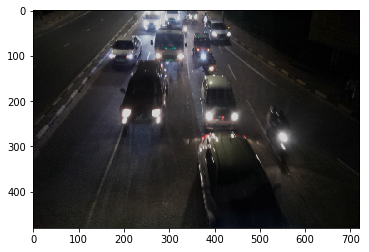

In [381]:
import cv2

im = cv2.imread("6.png")/255

im = erf(im)
im = (im*255).astype(np.uint8)

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

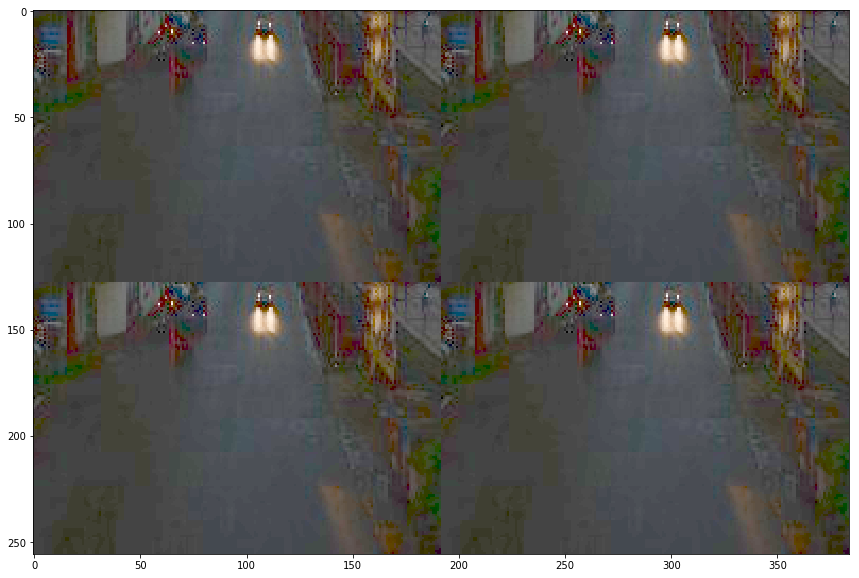

In [492]:
from scipy.special import betainc

def logit(x):
    return 2*(1 / (1 + np.exp(-x)))-1

def f(x, a, b, s, E):
    return ( (1-s)*x + s*a*((x/a)**E) ) ** ( np.log(b)/np.log(a) )

def g(x):
    return 0.5 * (1 + np.sin((x*np.pi)-(np.pi/2)))

def h(x, i, N):
    k = 0.5 * np.exp(i) / N
    return betainc(k, k, x)

from scipy.special import erf
im = cv2.imread("dark_merged.jpeg")/255
# im = f(im, 0.4, 0.5, 0.9,3)

# im = h(im,1,10)
im = im**(1/3)
# im = g(im)

im = (im*255).astype(np.uint8)

plt.figure(figsize=(20,10))

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

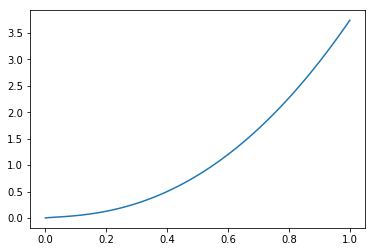

In [427]:
a = np.linspace(0,1,100)
b = f(a, 0.4, 0.5, 0.9,3)

plt.plot(a,b)

In [429]:
c = 0.5 * (1 + np.sin((a*np.pi)-(np.pi/2)))

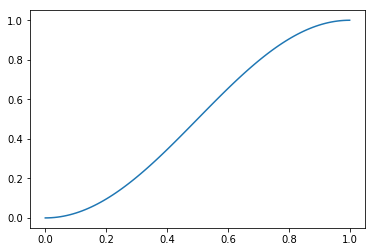

In [430]:
plt.plot(a,c)

In [19]:
def pad_edges(image, conv_units=8): # image.shape = (256, 384, 3)
    i = 1
    m = True
    max_factor = 2
    assert len(image.shape) == 3
    h,w,c  = image.shape
    blocks = h//conv_units
    image  = np.pad(image,((1,1),(0,0),(0,0)),mode = 'constant')
    
    image  = image.astype(np.float16)
    
    if c%2:
        c = c+1 
        h1,w1,_ = image.shape
        zeros = np.zeros((h1,w1,1), dtype=np.float16)
        image = np.concatenate([image,zeros], axis=2)

    im_arrays = [np.empty((0),dtype = np.float16), np.empty((0),dtype = np.float16)]
    for k in range(blocks):
        temp = image[k*conv_units:(k+1)*conv_units+2,:,:]
        temp = np.transpose(temp,[1,2,0]).flatten()
        im_arrays[k % 2] = np.append(im_arrays[k%2],temp)
    
    im_array = np.concatenate(im_arrays)
    
    return im_array

In [20]:
a = pad_edges(yolo[f'conv2d_1'].in_data[0]).shape

In [21]:
yolo[f'conv2d_1'].in_data[0].shape

(256, 384, 3)

In [34]:
np.frombuffer(np.array([17066], np.uint16).tobytes(), np.float16)

array([3.332], dtype=float16)

In [35]:
np.frombuffer(np.array([.2], np.float16).tobytes(), np.uint16)

array([12902], dtype=uint16)

In [31]:
np.array([1000], np.uint16)**9

array([0], dtype=uint16)

In [26]:
p = 2
num_units = 8
im = yolo[f'lrelu_3'].np_out_data[0]
H, W, cout = im.shape
itr = cout // p  # 3x3 no maxpool
b = H// num_units
im.shape

(64, 96, 128)

In [27]:
im = im.reshape((H,W,itr,p))
im.shape

(64, 96, 64, 2)

In [28]:
im = im.reshape((b,num_units, W, itr,p))
im.shape

(8, 8, 96, 64, 2)

In [29]:
im = im.transpose((3,0,2,4,1))
im.shape

(64, 8, 96, 2, 8)

In [30]:
im = im.flatten()
im.shape

(786432,)

In [31]:
with open("cores/mem_bin/3_out_itr1.bin", "rb") as f:
    t = f.read()
    
t = np.frombuffer(t, np.float16)

In [34]:
im = im[0:t.shape[0]]

In [36]:
np.sum(np.abs(im-t))/im.size

0.006235758463541667